# 1.Loading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file = kagglehub.dataset_download("carrie1/ecommerce-data",path="data.csv")
df = pd.read_csv(file, encoding="ISO-8859-1")
df.head(5)

/home/oussama/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df['CustomerID'].nunique()

4372

# 2. Preprocessing

In [7]:
df_cleaned = df.dropna(subset=['CustomerID'])

# 2. Remove rows with Quantity <= 0 or UnitPrice <= 0
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]

# 3. Remove canceled orders
df_cleaned = df_cleaned[~df_cleaned['InvoiceNo'].astype(str).str.startswith('C')]
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.shape

(397884, 8)

In [8]:
# Convert InvoiceDate to datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Reference date = one day after last purchase
reference_date = df_cleaned['InvoiceDate'].max() + pd.Timedelta(days=1)

# Compute total spent per row
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

# Group by customer to calculate RFM
rfm = df_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display first few rows
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [9]:
from sklearn.preprocessing import StandardScaler

# Extract RFM features
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert to DataFrame (optional)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Show first 5 rows
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,2.334574,-0.425097,8.358668
1,-0.905340,0.354417,0.250966
2,-0.175360,-0.035340,-0.028596
3,-0.735345,-0.425097,-0.033012
4,2.174578,-0.425097,-0.191347


# 3.Training

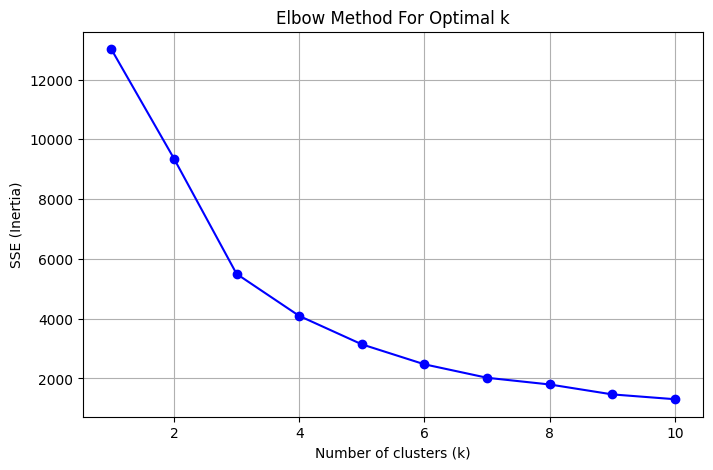

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try K from 1 to 10
sse = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    sse.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, sse, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [11]:
# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# Show sample
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).round(2)


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,40.98,4.85,2012.11,3231
1,246.02,1.58,631.14,1093
2,7.14,80.21,122888.41,14


In [12]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,1
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1


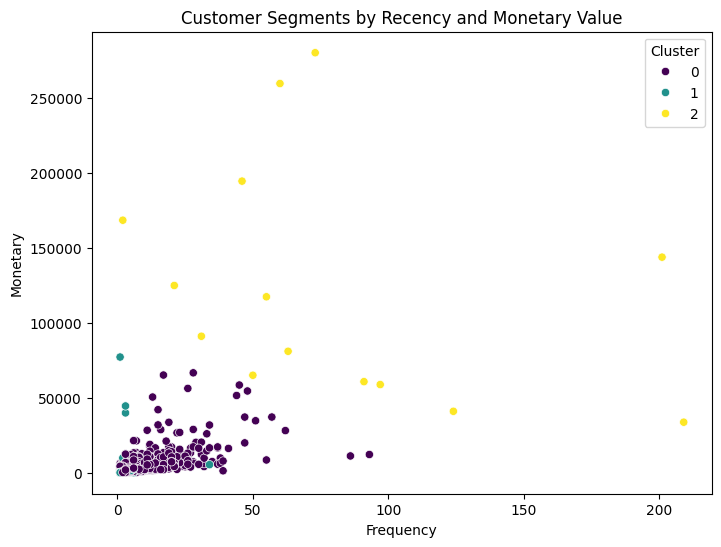

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2D Scatter Plot (Recency vs Monetary)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segments by Recency and Monetary Value')
plt.show()


In [14]:
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,2.334574,-0.425097,8.358668
1,-0.905340,0.354417,0.250966
2,-0.175360,-0.035340,-0.028596
3,-0.735345,-0.425097,-0.033012
4,2.174578,-0.425097,-0.191347


In [15]:
def label_cluster(row):
    if row['Cluster'] == 2:
        return 'VIP'
    elif row['Cluster'] == 0:
        return 'Regular'
    else:
        return 'Churn Risk'

rfm['Segment'] = rfm.apply(label_cluster, axis=1)

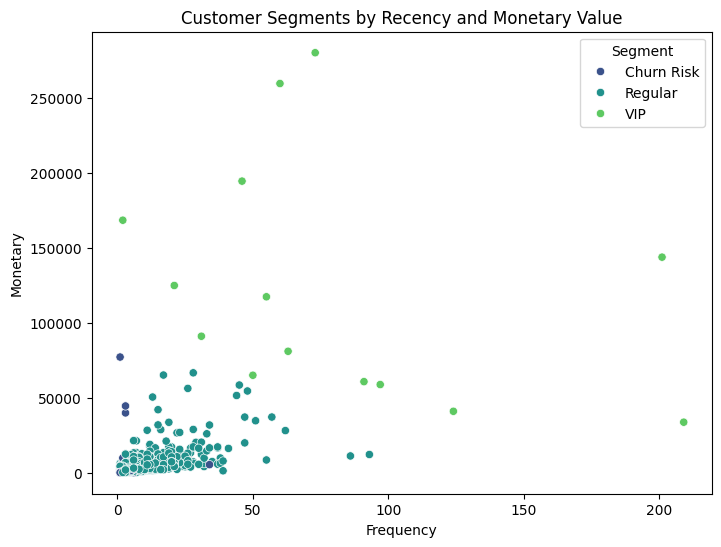

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='viridis')
plt.title('Customer Segments by Recency and Monetary Value')
plt.show()

# 4.Evaluation

In [17]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score,calinski_harabasz_score

# Estimate bandwidth for MeanShift

linkage_methods = ['ward', 'complete', 'average', 'single']

model = Birch(n_clusters=5)
ypred = model.fit_predict(rfm_scaled_df)
silhouette_avg = silhouette_score(rfm_scaled_df,ypred)
print(f"Silhouette Score: {silhouette_avg}")
davies_bouldin = davies_bouldin_score(rfm_scaled_df,ypred)
print(f"Davies-Bouldin Score: {davies_bouldin}")
calinski_harabasz = calinski_harabasz_score(rfm_scaled_df,ypred)
print(f"Calinski-Harabasz Score: {calinski_harabasz}")

Silhouette Score: 0.8009419644625876
Davies-Bouldin Score: 0.6146183004027471
Calinski-Harabasz Score: 925.3761517645216


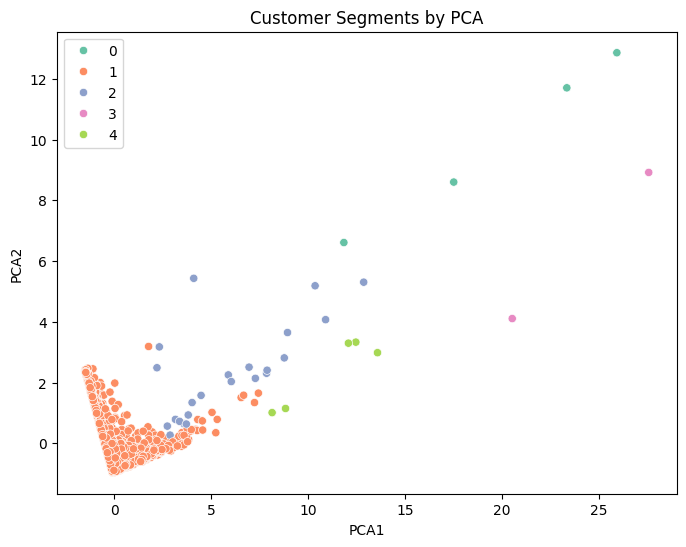

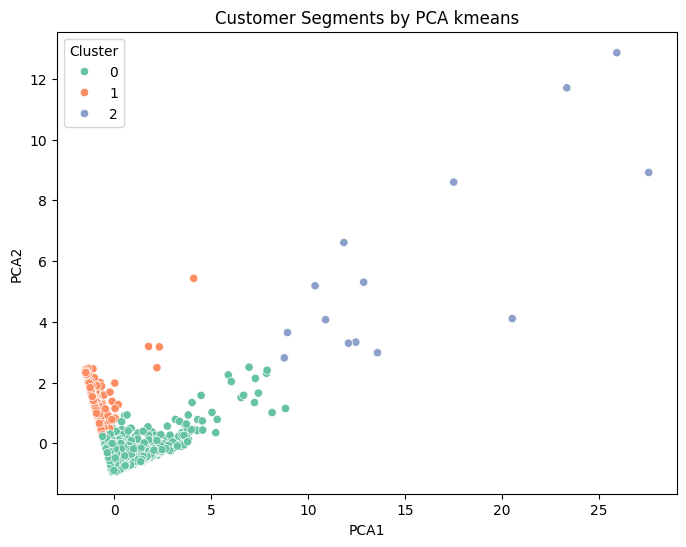

In [18]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled_df)

rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue=ypred, palette='Set2')
plt.title('Customer Segments by PCA')
plt.show()
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Customer Segments by PCA kmeans')
plt.show()

In [19]:

# Calculate Silhouette Score


# 4.Deployment

In [20]:
import tools
from preprocessor import Preprocessor



In [ ]:
def rfm_strategy(data,scaler,encoder):
    

np.int64(9288)

In [ ]:
n

Timedelta('1 days 00:00:00')